In [4]:
import numpy as np
from astropy.io import fits
from astropy.stats import sigma_clip
import glob
import os
from pathlib import Path

def create_master_bias(bias_folder, output_folder=None, combination_method='average',
                       use_sigma_clipping=True, sigma=3.0, maxiters=5):
    """
    Create master bias frame by combining mean and median methods with optional sigma clipping.
    
    Parameters:
    -----------
    bias_folder : str
        Path to folder containing bias frames
    output_folder : str, optional
        Path to save master bias frames. If None, saves to bias_folder
    combination_method : str, optional
        How to combine mean and median: 'average' (default) or 'weighted'
    use_sigma_clipping : bool, optional
        Whether to apply sigma clipping (default: True)
    sigma : float, optional
        Number of standard deviations for clipping (default: 3.0)
    maxiters : int, optional
        Maximum number of sigma clipping iterations (default: 5)
    
    Returns:
    --------
    master_bias : numpy.ndarray
        Master bias created by combining mean and median
    master_bias_mean : numpy.ndarray
        Intermediate mean master bias
    master_bias_median : numpy.ndarray
        Intermediate median master bias
    """
    
    # Set output folder
    if output_folder is None:
        output_folder = bias_folder
    
    # Get all FITS files in the bias folder
    bias_files = sorted(glob.glob(os.path.join(bias_folder, '*.fit*')))
    # Exclude master bias files
    bias_files = [f for f in bias_files if 'master' not in f.lower()]
    
    if not bias_files:
        raise ValueError(f"No FITS files found in {bias_folder}")
    
    print(f"Found {len(bias_files)} bias frames")
    print(f"Sigma clipping: {'Enabled' if use_sigma_clipping else 'Disabled'}")
    if use_sigma_clipping:
        print(f"  Sigma threshold: {sigma}")
        print(f"  Max iterations: {maxiters}")
    
    # Read the first frame to get dimensions
    with fits.open(bias_files[0]) as hdul:
        first_frame = hdul[0].data
        header = hdul[0].header.copy()
        print(f"Frame dimensions: {first_frame.shape}")
    
    # Create 3D array to hold all bias frames
    bias_cube = np.zeros((len(bias_files), *first_frame.shape), dtype=np.float32)
    
    # Load all bias frames
    print("\nLoading bias frames...")
    for i, bias_file in enumerate(bias_files):
        with fits.open(bias_file) as hdul:
            bias_cube[i] = hdul[0].data.astype(np.float32)
        
        if (i + 1) % 10 == 0:
            print(f"  Loaded {i + 1}/{len(bias_files)} frames")
    
    print("\nComputing master bias frames...")
    
    if use_sigma_clipping:
        print("  Applying sigma clipping...")
        # Apply sigma clipping along axis 0 (across frames for each pixel)
        clipped_data = sigma_clip(bias_cube, sigma=sigma, maxiters=maxiters, 
                                  axis=0, masked=True)
        
        # Count rejected pixels
        n_rejected = np.sum(clipped_data.mask)
        n_total = bias_cube.size
        rejection_rate = 100 * n_rejected / n_total
        print(f"  Rejected {n_rejected:,} / {n_total:,} values ({rejection_rate:.2f}%)")
        
        # Compute mean with clipped data
        print("  Computing clipped mean...")
        master_bias_mean = np.ma.mean(clipped_data, axis=0).data
        
        # Compute median with clipped data
        print("  Computing clipped median...")
        master_bias_median = np.ma.median(clipped_data, axis=0).data
        
        clipping_note = f"with {sigma}-sigma clipping"
    else:
        # No sigma clipping
        print("  Computing mean...")
        master_bias_mean = np.mean(bias_cube, axis=0)
        
        print("  Computing median...")
        master_bias_median = np.median(bias_cube, axis=0)
        
        clipping_note = "without sigma clipping"
    
    # Combine mean and median
    print(f"  Combining mean and median using '{combination_method}' method...")
    if combination_method == 'average':
        master_bias = (master_bias_mean + master_bias_median) / 2.0
        comb_desc = 'Average of mean and median'
    elif combination_method == 'weighted':
        master_bias = 0.3 * master_bias_mean + 0.7 * master_bias_median
        comb_desc = 'Weighted combination (30% mean, 70% median)'
    else:
        raise ValueError(f"Unknown combination method: {combination_method}")
    
    # Update header with processing information
    header['HISTORY'] = f'Master bias created from {len(bias_files)} frames'
    header['NCOMBINE'] = len(bias_files)
    header['COMBMETH'] = f'MEAN+MEDIAN'
    header['HISTORY'] = f'Combined using {comb_desc}'
    header['HISTORY'] = f'Processed {clipping_note}'
    if use_sigma_clipping:
        header['SIGCLIP'] = True
        header['SIGTHRES'] = sigma
        header['SIGMITER'] = maxiters
        header['REJRATE'] = (rejection_rate, 'Rejection rate (%)')
    
    # Save combined master bias
    print("\nSaving master bias frames...")
    combined_filename = os.path.join(output_folder, 'master_bias_combined.fits')
    fits.writeto(combined_filename, master_bias.astype(np.float32), 
                 header, overwrite=True)
    print(f"  Saved combined master bias: {combined_filename}")
    
    # Save individual mean and median for comparison
    header_mean = header.copy()
    header_mean['COMBMETH'] = 'MEAN'
    mean_filename = os.path.join(output_folder, 'master_bias_mean.fits')
    fits.writeto(mean_filename, master_bias_mean.astype(np.float32), 
                 header_mean, overwrite=True)
    print(f"  Saved mean master bias: {mean_filename}")
    
    header_median = header.copy()
    header_median['COMBMETH'] = 'MEDIAN'
    median_filename = os.path.join(output_folder, 'master_bias_median.fits')
    fits.writeto(median_filename, master_bias_median.astype(np.float32), 
                 header_median, overwrite=True)
    print(f"  Saved median master bias: {median_filename}")
    
    # Print statistics
    print("\n" + "="*60)
    print("STATISTICS")
    print("="*60)
    print(f"Mean master bias     - Mean: {np.mean(master_bias_mean):.2f}, "
          f"Std: {np.std(master_bias_mean):.2f}")
    print(f"Median master bias   - Mean: {np.mean(master_bias_median):.2f}, "
          f"Std: {np.std(master_bias_median):.2f}")
    print(f"Combined master bias - Mean: {np.mean(master_bias):.2f}, "
          f"Std: {np.std(master_bias):.2f}")
    
    return master_bias, master_bias_mean, master_bias_median


# Main execution
if __name__ == "__main__":
    # Bias folder path
    bias_folder = "/home/devika/PhD/S2/Obs_Astronomy/Image_Processing/Ckoirama_2025-12-19/BIAS"
    
    # Create master bias frames
    # Options: 
    #   combination_method: 'average' (50-50) or 'weighted' (30% mean, 70% median)
    #   use_sigma_clipping: True/False
    #   sigma: typically 3.0 (can use 2.5 for more aggressive clipping)
    try:
        master_combined, master_mean, master_median = create_master_bias(
            bias_folder, 
            combination_method='average',
            use_sigma_clipping=True,  # Set to False to disable
            sigma=3.0,                # Number of standard deviations
            maxiters=5                # Maximum clipping iterations
        )
        print("\n" + "="*60)
        print("Master bias frames created successfully!")
        print(f"Primary output: master_bias_combined.fits")
        print("="*60)
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()

Found 102 bias frames
Sigma clipping: Enabled
  Sigma threshold: 3.0
  Max iterations: 5
Frame dimensions: (2048, 2048)

Loading bias frames...
  Loaded 10/102 frames
  Loaded 20/102 frames
  Loaded 30/102 frames
  Loaded 40/102 frames
  Loaded 50/102 frames
  Loaded 60/102 frames
  Loaded 70/102 frames
  Loaded 80/102 frames
  Loaded 90/102 frames
  Loaded 100/102 frames

Computing master bias frames...
  Applying sigma clipping...
  Rejected 1,234,691 / 427,819,008 values (0.29%)
  Computing clipped mean...
  Computing clipped median...
  Combining mean and median using 'average' method...

Saving master bias frames...
  Saved combined master bias: /home/devika/PhD/S2/Obs_Astronomy/Image_Processing/Ckoirama_2025-12-19/BIAS/master_bias_combined.fits
  Saved mean master bias: /home/devika/PhD/S2/Obs_Astronomy/Image_Processing/Ckoirama_2025-12-19/BIAS/master_bias_mean.fits
  Saved median master bias: /home/devika/PhD/S2/Obs_Astronomy/Image_Processing/Ckoirama_2025-12-19/BIAS/master_bias

# Visualization

Loading and visualizing bias frames...

Loaded: Raw Bias (Frame 1)
Loaded: Mean Master Bias
Loaded: Median Master Bias
Loaded: Combined Master Bias

Figure saved: /home/devika/PhD/S2/Obs_Astronomy/Image_Processing/Ckoirama_2025-12-19/BIAS/bias_comparison.tif


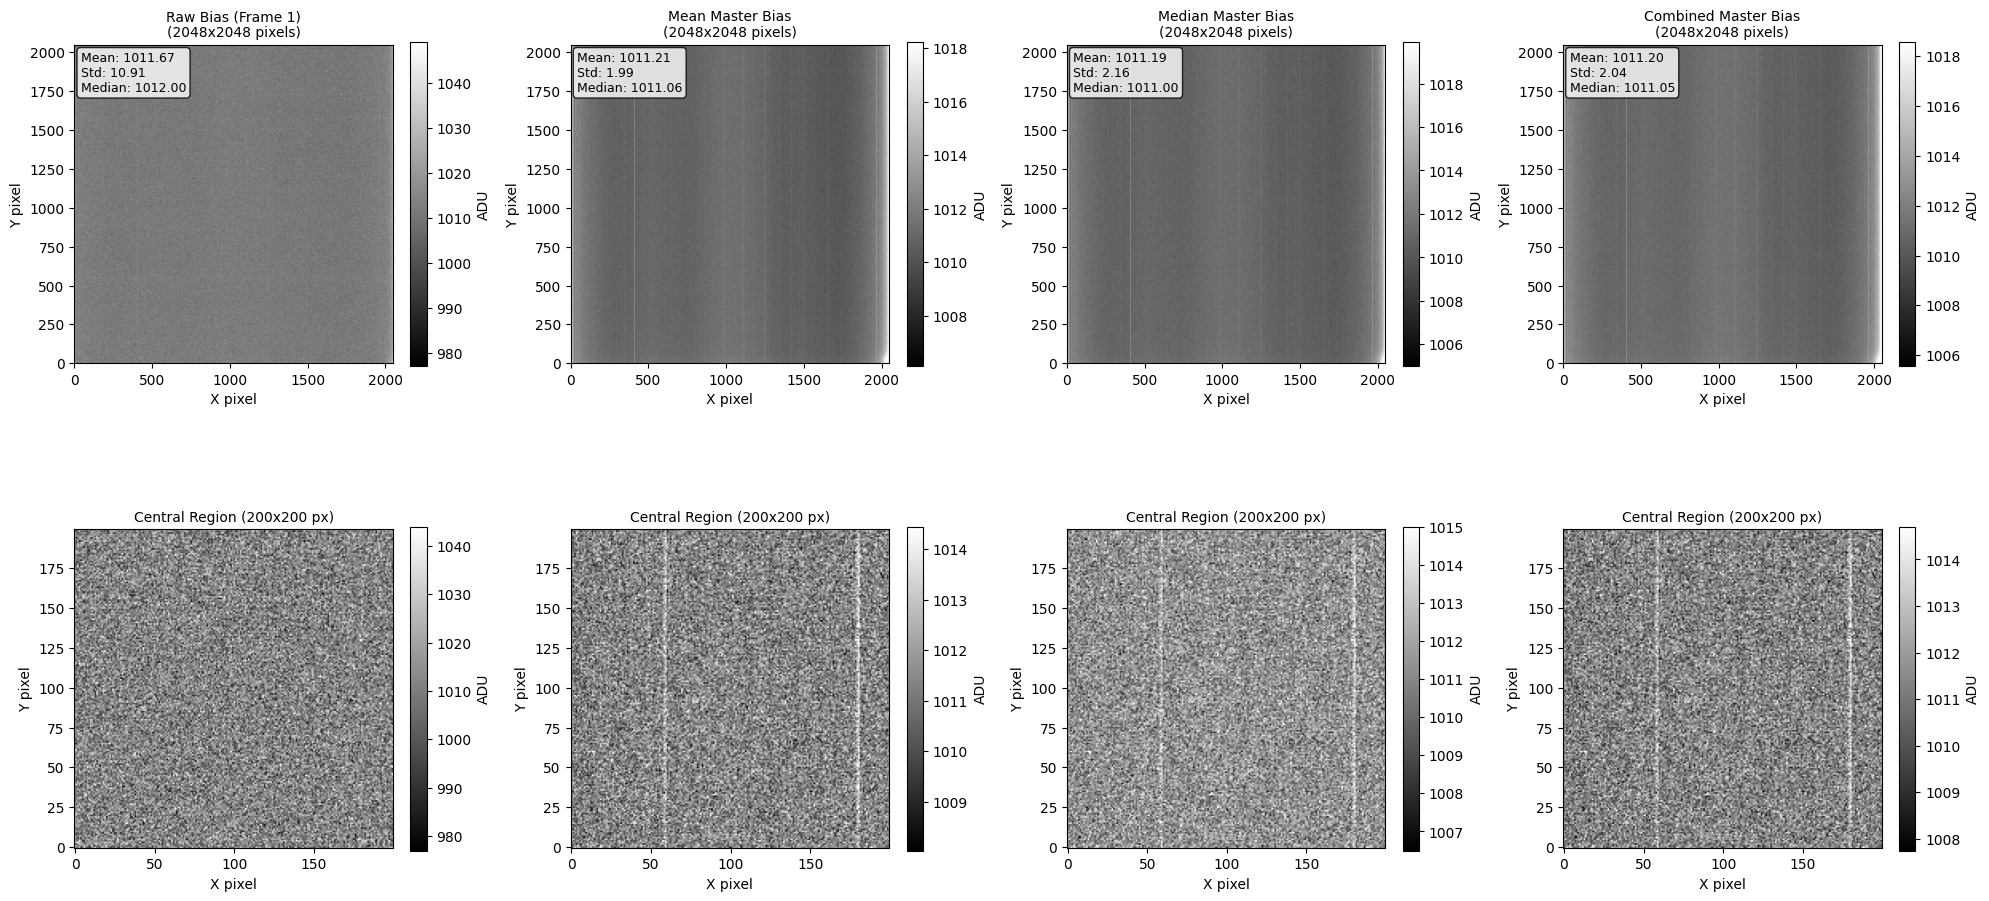

Histogram saved: /home/devika/PhD/S2/Obs_Astronomy/Image_Processing/Ckoirama_2025-12-19/BIAS/bias_histogram.tif


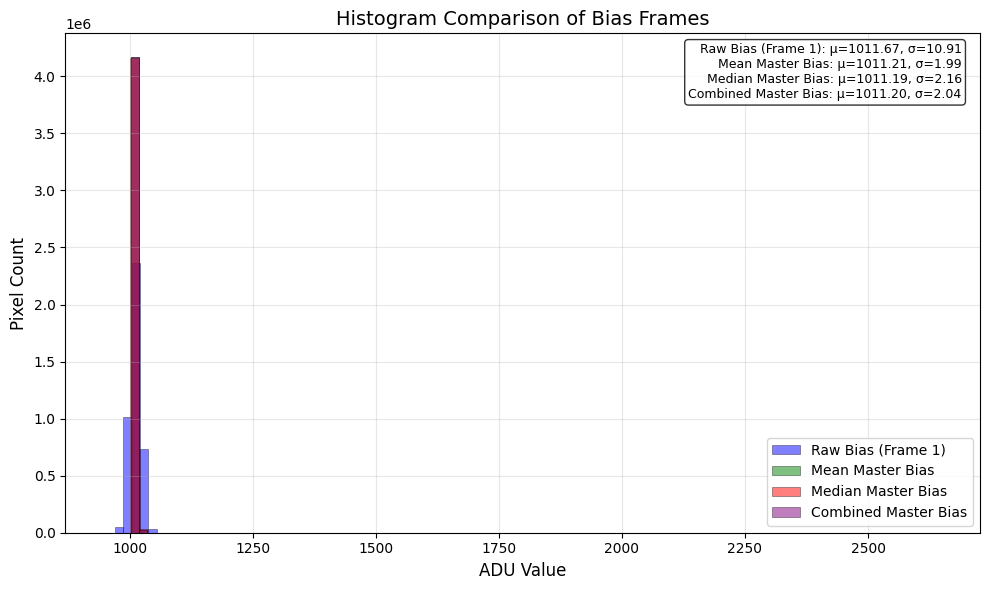


DETAILED STATISTICS

Raw Bias (Frame 1):
  Shape:      (2048, 2048)
  Mean:       1011.6659 ADU
  Median:     1012.0000 ADU
  Std Dev:    10.9120 ADU
  Min:        954.0000 ADU
  Max:        2640.0000 ADU
  Range:      1686.0000 ADU

Mean Master Bias:
  Shape:      (2048, 2048)
  Mean:       1011.2064 ADU
  Median:     1011.0588 ADU
  Std Dev:    1.9934 ADU
  Min:        1002.8020 ADU
  Max:        2642.8530 ADU
  Range:      1640.0510 ADU

Median Master Bias:
  Shape:      (2048, 2048)
  Mean:       1011.1901 ADU
  Median:     1011.0000 ADU
  Std Dev:    2.1584 ADU
  Min:        1002.0000 ADU
  Max:        2642.5000 ADU
  Range:      1640.5000 ADU

Combined Master Bias:
  Shape:      (2048, 2048)
  Mean:       1011.1974 ADU
  Median:     1011.0539 ADU
  Std Dev:    2.0382 ADU
  Min:        1002.7500 ADU
  Max:        2642.6765 ADU
  Range:      1639.9265 ADU


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.visualization import ZScaleInterval
import os

def visualize_bias_frames(bias_folder):
    """
    Visualize raw, mean, median, and combined master bias frames.
    
    Parameters:
    -----------
    bias_folder : str
        Path to folder containing bias frames and master bias files
    """
    
    # File paths
    raw_bias_path = None
    mean_path = os.path.join(bias_folder, 'master_bias_mean.fits')
    median_path = os.path.join(bias_folder, 'master_bias_median.fits')
    combined_path = os.path.join(bias_folder, 'master_bias_combined.fits')
    
    # Get first raw bias frame
    import glob
    raw_files = sorted(glob.glob(os.path.join(bias_folder, '*.fit*')))
    raw_files = [f for f in raw_files if 'master' not in f.lower()]
    
    if raw_files:
        raw_bias_path = raw_files[0]
    
    # Check which files exist
    files_to_load = {
        'Raw Bias (Frame 1)': raw_bias_path,
        'Mean Master Bias': mean_path,
        'Median Master Bias': median_path,
        'Combined Master Bias': combined_path
    }
    
    # Load the frames
    frames = {}
    for name, path in files_to_load.items():
        if path and os.path.exists(path):
            with fits.open(path) as hdul:
                frames[name] = hdul[0].data.astype(np.float32)
            print(f"Loaded: {name}")
        else:
            print(f"Not found: {name}")
    
    if not frames:
        print("No bias frames found!")
        return
    
    # Create figure with subplots
    n_frames = len(frames)
    fig, axes = plt.subplots(2, n_frames, figsize=(5*n_frames, 10))
    
    if n_frames == 1:
        axes = axes.reshape(2, 1)
    
    # Use ZScale for better contrast
    zscale = ZScaleInterval()
    
    # Plot each frame
    for idx, (name, data) in enumerate(frames.items()):
        # Top row: Full frame
        ax_full = axes[0, idx]
        vmin, vmax = zscale.get_limits(data)
        im = ax_full.imshow(data, cmap='gray', origin='lower', 
                           vmin=vmin, vmax=vmax)
        ax_full.set_title(f'{name}\n({data.shape[0]}x{data.shape[1]} pixels)', 
                         fontsize=10)
        ax_full.set_xlabel('X pixel')
        ax_full.set_ylabel('Y pixel')
        plt.colorbar(im, ax=ax_full, label='ADU', fraction=0.046)
        
        # Add statistics
        mean_val = np.mean(data)
        std_val = np.std(data)
        median_val = np.median(data)
        ax_full.text(0.02, 0.98, f'Mean: {mean_val:.2f}\nStd: {std_val:.2f}\nMedian: {median_val:.2f}',
                    transform=ax_full.transAxes, fontsize=9,
                    verticalalignment='top', bbox=dict(boxstyle='round', 
                    facecolor='white', alpha=0.8))
        
        # Bottom row: Zoomed region (central 200x200 pixels)
        ax_zoom = axes[1, idx]
        h, w = data.shape
        center_y, center_x = h // 2, w // 2
        zoom_size = 100
        zoom_data = data[center_y-zoom_size:center_y+zoom_size, 
                        center_x-zoom_size:center_x+zoom_size]
        
        vmin_zoom, vmax_zoom = zscale.get_limits(zoom_data)
        im_zoom = ax_zoom.imshow(zoom_data, cmap='gray', origin='lower',
                                vmin=vmin_zoom, vmax=vmax_zoom)
        ax_zoom.set_title(f'Central Region (200x200 px)', fontsize=10)
        ax_zoom.set_xlabel('X pixel')
        ax_zoom.set_ylabel('Y pixel')
        plt.colorbar(im_zoom, ax=ax_zoom, label='ADU', fraction=0.046)
    
    plt.tight_layout()
    
    # Save figure
    output_path = os.path.join(bias_folder, 'bias_comparison.png')
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    print(f"\nFigure saved: {output_path}")
    plt.show()
    
    # Create histogram comparison
    if len(frames) > 1:
        fig2, ax = plt.subplots(1, 1, figsize=(10, 6))
        
        colors = ['blue', 'green', 'red', 'purple']
        for (name, data), color in zip(frames.items(), colors):
            ax.hist(data.flatten(), bins=100, alpha=0.5, label=name, 
                   color=color, edgecolor='black', linewidth=0.5)
        
        ax.set_xlabel('ADU Value', fontsize=12)
        ax.set_ylabel('Pixel Count', fontsize=12)
        ax.set_title('Histogram Comparison of Bias Frames', fontsize=14)
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)
        
        # Add statistics text
        stats_text = ""
        for name, data in frames.items():
            stats_text += f"{name}: μ={np.mean(data):.2f}, σ={np.std(data):.2f}\n"
        
        ax.text(0.98, 0.98, stats_text.strip(), transform=ax.transAxes,
               fontsize=9, verticalalignment='top', horizontalalignment='right',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        plt.tight_layout()
        hist_path = os.path.join(bias_folder, 'bias_histogram.png')
        plt.savefig(hist_path, dpi=150, bbox_inches='tight')
        print(f"Histogram saved: {hist_path}")
        plt.show()
    
    # Print detailed statistics
    print("\n" + "="*60)
    print("DETAILED STATISTICS")
    print("="*60)
    for name, data in frames.items():
        print(f"\n{name}:")
        print(f"  Shape:      {data.shape}")
        print(f"  Mean:       {np.mean(data):.4f} ADU")
        print(f"  Median:     {np.median(data):.4f} ADU")
        print(f"  Std Dev:    {np.std(data):.4f} ADU")
        print(f"  Min:        {np.min(data):.4f} ADU")
        print(f"  Max:        {np.max(data):.4f} ADU")
        print(f"  Range:      {np.max(data) - np.min(data):.4f} ADU")


# Main execution
if __name__ == "__main__":
    bias_folder = "/home/devika/PhD/S2/Obs_Astronomy/Image_Processing/Ckoirama_2025-12-19/BIAS"
    
    print("Loading and visualizing bias frames...\n")
    visualize_bias_frames(bias_folder)